In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! pip install mtcnn

In [ ]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


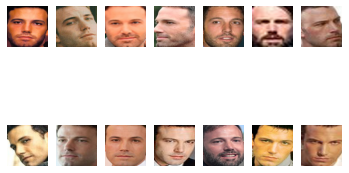

In [ ]:
# demonstrate face detection on 5 Celebrity Faces Dataset

from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# specify folder to plot
folder = './gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# enumerate files
for filename in listdir(folder):
	# path
	path = folder + filename
	# get face
	face = extract_face(path,(160, 160))
	print(i, face.shape)
	# plot
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()



In [ ]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path,(160, 160))
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('./gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('./gdrive/My Drive/facenet/images/5-celebrity-faces-dataset/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 14 examples for class: ben_afflek
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: jerry_seinfeld


In [ ]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
modelem = load_model('./gdrive/My Drive/facenet/model/facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(modelem, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(modelem, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


In [ ]:
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


test embeddings
[[ 0.55816376 -1.0386937   0.2877693  ...  0.5701822  -0.89292645
  -0.41056496]
 [ 0.5457368   0.58582413  0.26587948 ...  0.33544955  0.01656884
  -1.8528092 ]
 [ 0.16293043 -0.08890791 -0.42409724 ...  1.9795915   1.0397247
  -1.5657161 ]
 ...
 [-0.29627568  1.0099963   0.7117859  ... -0.41162765 -0.6217696
   0.26491714]
 [-0.98317516  0.17266837  0.590476   ...  0.78461635  0.14125383
  -0.47834834]
 [ 0.70483637 -0.40887523  0.31171164 ... -0.8714711  -0.32130867
  -0.9731699 ]]
(128,)
test
[[ 0.0483934  -0.09005586  0.02494991 ...  0.04943541 -0.07741769
  -0.03559642]
 [ 0.05068954  0.05441296  0.02469562 ...  0.03115748  0.00153896
  -0.17209402]
 [ 0.01370651 -0.00747937 -0.03567716 ...  0.16653304  0.08746679
  -0.1317158 ]
 ...
 [-0.02652618  0.09042706  0.06372767 ... -0.03685388 -0.05566832
   0.02371858]
 [-0.08154999  0.01432207  0.04897735 ...  0.06508043  0.01171638
  -0.03967686]
 [ 0.06155426 -0.0357076   0.02722218 ... -0.07610669 -0.0280603
  -0.08

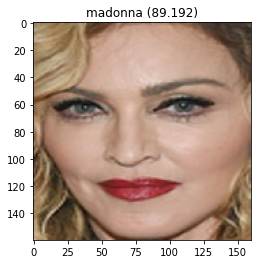

In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data2 = load('5-celebrity-faces-dataset.npz')
testX_faces = data2['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testXem, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testXem)
print("test embeddings")
print(testXem)
print(testXem[0].shape)
print("test")
print(testX)
print(testX.shape)
print(testX[0].shape)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
modelsvc = SVC(kernel='linear', probability=True)
modelsvc.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
print("random_face_emb",testX[selection])
print(testX[selection].shape)
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
print("samples:",samples)
print(samples.shape)
yhat_class = modelsvc.predict(samples)
yhat_prob = modelsvc.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

Testing

Emotion Recognition

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import keras
from keras.preprocessing import image

from keras import applications as keras_applications

!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

from keras_vggface.vggface import VGGFace
from keras_vggface import utils



  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-dm5mc1ol
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-dm5mc1ol
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=8056724227ddf917d683961cbdc489dc4bee725b7484ecb2ee2dad7d2d376304
  Stored in directory: /tmp/pip-ephem-wheel-cache-fdnpin_p/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
import keras
from keras.preprocessing import image
from keras import applications as keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [ ]:
os.system('tar -xf /kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz');
data = pd.read_csv('/content/gdrive/MyDrive/facenet/fer2013/fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
data.Usage.unique()
train_data = data[data.Usage=='Training']
val_data = data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']
train_data.shape, val_data.shape, test_data.shape

((28709, 3), (3589, 3), (3589, 3))

In [ ]:
!pip install imblearn
import collections
import imblearn
from imblearn import under_sampling, over_sampling
oversampler = imblearn.over_sampling.RandomOverSampler()

In [ ]:
collections.Counter(train_data.emotion)

Counter({0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965})

In [ ]:
from keras.utils import to_categorical

x_train, y_train = oversampler.fit_resample(train_data.pixels.values.reshape(-1,1),train_data.emotion.values)

# x_train = train_data.pixels.values.reshape(-1,1)
# y_train = train_data.emotion.values

x_val = val_data.pixels.values.reshape(-1,1)
y_val = val_data.emotion.values

x_test = test_data.pixels.values.reshape(-1,1)
y_test = test_data.emotion.values

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
collections.Counter(y_train)

Counter({0: 7215, 1: 7215, 2: 7215, 3: 7215, 4: 7215, 5: 7215, 6: 7215})

In [ ]:
y_train = to_categorical(y_train,num_classes=7)
y_val   = to_categorical(y_val  ,num_classes=7)
y_test  = to_categorical(y_test ,num_classes=7)

In [ ]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [ ]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
x_train = list(x_train)
x_val   = list(x_val)
x_test  = list(x_test)

for i,item in enumerate(x_train):
    x_train[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_val):
    x_val[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
for i,item in enumerate(x_test):
    x_test[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
    
x_train = np.vstack(x_train).reshape(-1,48,48,1)
x_val = np.vstack(x_val).reshape(-1,48,48,1)
x_test = np.vstack(x_test).reshape(-1,48,48,1)

In [ ]:
train_sequence = data_sequence(x_train,y_train,batch_size=16,target_dim=(224,224),n_classes=7,shuffle=False)
feature,lable = train_sequence.__getitem__(0)
print(train_sequence)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


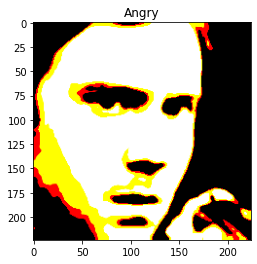

In [ ]:
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

import matplotlib.pyplot as plt
plt.imshow(feature[0,:,:,:])
plt.title(emotion_dict[np.argmax(lable[0])]);

In [ ]:
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))
vggface.trainable = False
vggface.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_800 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_800[0][0]                  
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

emotionalmodel = Sequential([vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(2048, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
emotionalmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_533 (Flatten)        (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1864 (Dense)           (None, 2048)              4196352   
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1865 (Dense)           (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                

In [ ]:
train_sequence = data_sequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(x_val,  y_val,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

Epoch 1/5
789/789 [==============================] - 161s 204ms/step - loss: 1.2253 - accuracy: 0.5739 - val_loss: 1.0598 - val_accuracy: 0.6099
Epoch 2/5
789/789 [==============================] - 159s 202ms/step - loss: 0.8526 - accuracy: 0.6839 - val_loss: 1.0342 - val_accuracy: 0.6172
Epoch 3/5
789/789 [==============================] - 160s 203ms/step - loss: 0.7413 - accuracy: 0.7302 - val_loss: 1.0071 - val_accuracy: 0.6356
Epoch 4/5
789/789 [==============================] - 159s 202ms/step - loss: 0.6524 - accuracy: 0.7635 - val_loss: 1.0783 - val_accuracy: 0.6119
Epoch 5/5
789/789 [==============================] - 160s 202ms/step - loss: 0.5818 - accuracy: 0.7913 - val_loss: 1.0235 - val_accuracy: 0.6342


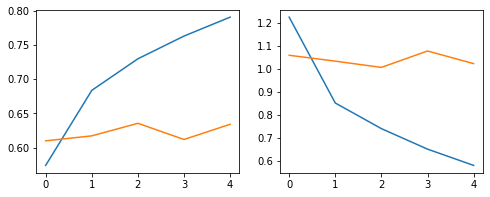

In [ ]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
hist = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

Epoch 1/5
789/789 [==============================] - 160s 203ms/step - loss: 0.3948 - accuracy: 0.8599 - val_loss: 1.0399 - val_accuracy: 0.6585
Epoch 2/5
789/789 [==============================] - 160s 202ms/step - loss: 0.3421 - accuracy: 0.8790 - val_loss: 1.0561 - val_accuracy: 0.6652
Epoch 3/5
789/789 [==============================] - 160s 203ms/step - loss: 0.3092 - accuracy: 0.8904 - val_loss: 1.0768 - val_accuracy: 0.6694
Epoch 4/5
789/789 [==============================] - 159s 202ms/step - loss: 0.2779 - accuracy: 0.9005 - val_loss: 1.0957 - val_accuracy: 0.6660
Epoch 5/5
789/789 [==============================] - 159s 202ms/step - loss: 0.2629 - accuracy: 0.9060 - val_loss: 1.1208 - val_accuracy: 0.6719


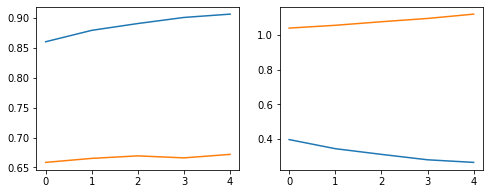

In [ ]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

Epoch 1/5
789/789 [==============================] - 160s 203ms/step - loss: 0.2304 - accuracy: 0.9192 - val_loss: 1.1326 - val_accuracy: 0.6730
Epoch 2/5
789/789 [==============================] - 159s 202ms/step - loss: 0.2249 - accuracy: 0.9196 - val_loss: 1.1346 - val_accuracy: 0.6744
Epoch 3/5
789/789 [==============================] - 159s 202ms/step - loss: 0.2217 - accuracy: 0.9207 - val_loss: 1.1384 - val_accuracy: 0.6747
Epoch 4/5
789/789 [==============================] - 159s 202ms/step - loss: 0.2185 - accuracy: 0.9215 - val_loss: 1.1422 - val_accuracy: 0.6752
Epoch 5/5
789/789 [==============================] - 160s 202ms/step - loss: 0.2152 - accuracy: 0.9235 - val_loss: 1.1450 - val_accuracy: 0.6752


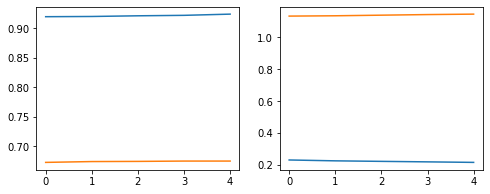

In [ ]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
hist = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 5)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

Epoch 1/10
789/789 [==============================] - 160s 203ms/step - loss: 0.2258 - accuracy: 0.9197 - val_loss: 1.1616 - val_accuracy: 0.6722
Epoch 2/10
789/789 [==============================] - 160s 202ms/step - loss: 0.2095 - accuracy: 0.9261 - val_loss: 1.1807 - val_accuracy: 0.6738
Epoch 3/10
789/789 [==============================] - 160s 202ms/step - loss: 0.1963 - accuracy: 0.9307 - val_loss: 1.1899 - val_accuracy: 0.6719
Epoch 4/10
789/789 [==============================] - 159s 202ms/step - loss: 0.1879 - accuracy: 0.9328 - val_loss: 1.2312 - val_accuracy: 0.6682
Epoch 5/10
789/789 [==============================] - 160s 203ms/step - loss: 0.1758 - accuracy: 0.9383 - val_loss: 1.2241 - val_accuracy: 0.6677
Epoch 6/10
789/789 [==============================] - 160s 203ms/step - loss: 0.1655 - accuracy: 0.9411 - val_loss: 1.2568 - val_accuracy: 0.6705
Epoch 7/10
789/789 [==============================] - 160s 202ms/step - loss: 0.1546 - accuracy: 0.9459 - val_loss: 1.2762 -

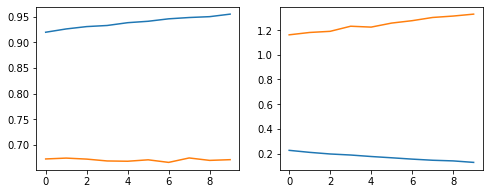

In [ ]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

In [ ]:
emotionalmodel.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = emotionalmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 20)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

Epoch 1/20
789/789 [==============================] - 160s 203ms/step - loss: 0.0630 - accuracy: 0.9778 - val_loss: 1.6763 - val_accuracy: 0.6749
Epoch 2/20
680/789 [========================>.....] - ETA: 20s - loss: 0.0647 - accuracy: 0.9775

KeyboardInterrupt: ignored

In [ ]:
emotionalmodel.evaluate(test_sequence)
print(len(test_sequence))

56/56 [==============================] - 10s 184ms/step - loss: 1.4415 - accuracy: 0.6917
56


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


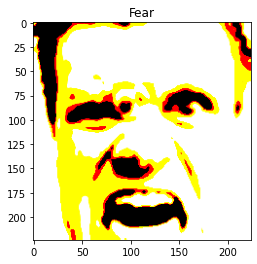

In [ ]:
feature2,lable2 = test_sequence.__getitem__(0)
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

import matplotlib.pyplot as plt
plt.imshow(feature2[0,:,:,:])
plt.title(emotion_dict[np.argmax(lable2[0])]);


In [ ]:
res=emotionalmodel.predict(feature2)
print(emotion_dict[np.argmax(res[0])])

Angry


Testing on an arbitary image

In [ ]:
image='/content/gdrive/MyDrive/facenet/images/5-celebrity-faces-dataset/mindysad.jpg'
#face recognition
facearray=extract_face(image,(160, 160))
embedding2 = get_embedding(modelem, facearray)
li=[]
li.append(embedding2)
in_encoder = Normalizer(norm='l2')
random_face_emb2 = in_encoder.transform(li)
samples2 = expand_dims(random_face_emb2[0], axis=0)
yhat_class2 = modelsvc.predict(samples2)
yhat_prob2 = modelsvc.predict_proba(samples)
class_index2 = yhat_class2[0]
predict_names2 = out_encoder.inverse_transform(yhat_class2)

#emotion detection
facearrayem=extract_face(image,(224, 224))
facearrayem = facearrayem.astype('float32')
X = utils.preprocess_input(facearrayem, version=2) # or version=2 for VGGFace2 ResNet50  
X = np.array(X)
ls=np.array([X])
res2=emotionalmodel.predict(ls)


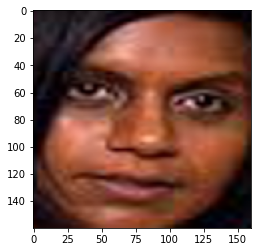

mindy_kaling is feeling Angry today


In [ ]:
pyplot.imshow(facearray)
pyplot.show()
print(predict_names2[0],"is feeling",emotion_dict[np.argmax(res2[0])],"today")